# House Sale Price Predicition

## Imports

In [12]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


## Global Varibles

In [2]:
CMAP = sns.diverging_palette(220, 10, as_cmap=True)
TARGET_VAR = "SalePrice"

## Local Functions

In [33]:
def multi_hist(df, col_names: list, max_col = 4):
    rows = (len(col_names) - 1) // max_col + 1
    fig = make_subplots(rows=rows, cols=max_col, subplot_titles=col_names)
    for i, feat in enumerate(col_names):
        j = i + 1
        row =  i//max_col + 1
        col = (j % max_col) if (j % max_col) != 0 else max_col
        fig.add_trace(
            go.Histogram(x=df[feat]),
            row = row, col = col
        )
    fig.update_layout(showlegend=False)
    fig.show()

def corrfunc(x, y, ax=None, **kws):
    # https://stackoverflow.com/questions/50832204/show-correlation-values-in-pairplot-using-seaborn-in-python
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    try:
        r, _ = pearsonr(x, y)
        ax = ax or plt.gca()
        ax.annotate(f'p = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    except Exception:
        pass

def multi_scatmat(df, target_col, max_col=10):
    for i in range(1, len(df.columns), max_col):
        # Creating smaller dataset
        sm_df = df[df.columns[i:i+max_col+1]]
        sm_df[target_col] = df[target_col]
        
        # Scatterplot Matrix
        g = sns.pairplot(sm_df)
        g.map_lower(corrfunc)
        plt.show()

        # Heatmap
        sns.heatmap(sm_df.corr(), vmax=.3, center=0, cmap=CMAP, square=True, linewidths=.5, cbar_kws={"shrink":.5})

def nulls_df(df):
    df_nan = pd.DataFrame(df.isnull().sum())
    df_nan.columns = ["nulls"]
    return df_nan

def multi_bar(df, col_names: list, target_col, max_col = 4):
    rows = (len(col_names) - 1) // max_col + 1
    fig = make_subplots(rows=rows, cols=max_col, subplot_titles=col_names)
    for i, feat in enumerate(col_names):
        j = i + 1
        row =  i//max_col + 1
        col = (j % max_col) if (j % max_col) != 0 else max_col
        fig.add_trace(
            go.Bar(x=df[feat], y=df[target_col]),
            row = row, col = col
        )
    fig.update_layout(showlegend=False)
    fig.show()

In [25]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")


## Exploratory Data Analysis

In [27]:
test_nulls = nulls_df(test)
train_nulls = nulls_df(train)

train_nulls[train_nulls['nulls'] > 0]

,nulls
LotFrontage,259
Alley,1369
MasVnrType,8
MasVnrArea,8
BsmtQual,37
BsmtCond,37
BsmtExposure,38
BsmtFinType1,37
BsmtFinType2,38
Electrical,1


In the interest of generalisation, let's remove these columns altogether as most of this information tends to be hard to gather anyway. 

In [29]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [30]:
multi_hist(train, ["YrSold", "YearBuilt", "SalePrice", "LotArea", "HouseStyle", "OverallCond", "FullBath", "BedroomAbvGr", "TotRmsAbvGrd"], 3)

Intuitively, features such as 
- YearBuilt
- HouseStyle
- OverallCond

would presumably have an effect on SalePrice, let's check them in isolation

In [34]:
multi_bar(train, ["YearBuilt", "HouseStyle", "OverallCond"], TARGET_VAR)

We can definitely see a somewhat non-linear positive relationship between YearBuilt and SalePrice, whereas HouseStyles: 2Story and 1Story sell for much more

In [37]:
pd.pivot_table(train, index=['HouseStyle'], values="SalePrice")

,SalePrice
HouseStyle,
1.5Fin,143116.740260
1.5Unf,110150.000000
1Story,175985.477961
2.5Fin,220000.000000
2.5Unf,157354.545455
2Story,210051.764045
SFoyer,135074.486486
SLvl,166703.384615


In [38]:
pd.pivot_table(train, index=['OverallCond'], values="SalePrice")

,SalePrice
OverallCond,
1,61000.000000
2,141986.400000
3,101929.400000
4,120438.438596
5,203146.914738
6,153961.591270
7,158145.487805
8,155651.736111
9,216004.545455


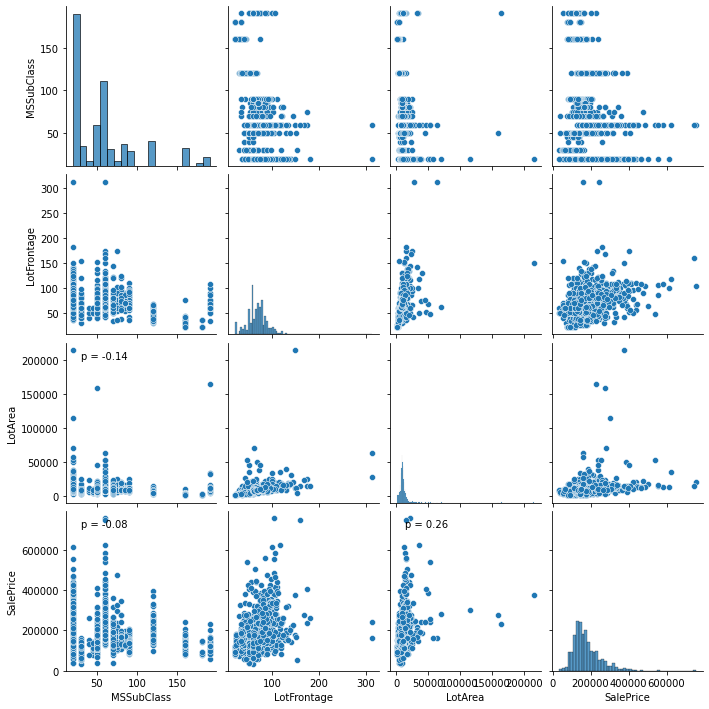

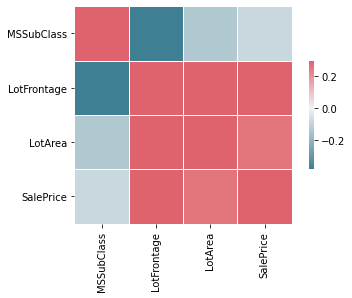

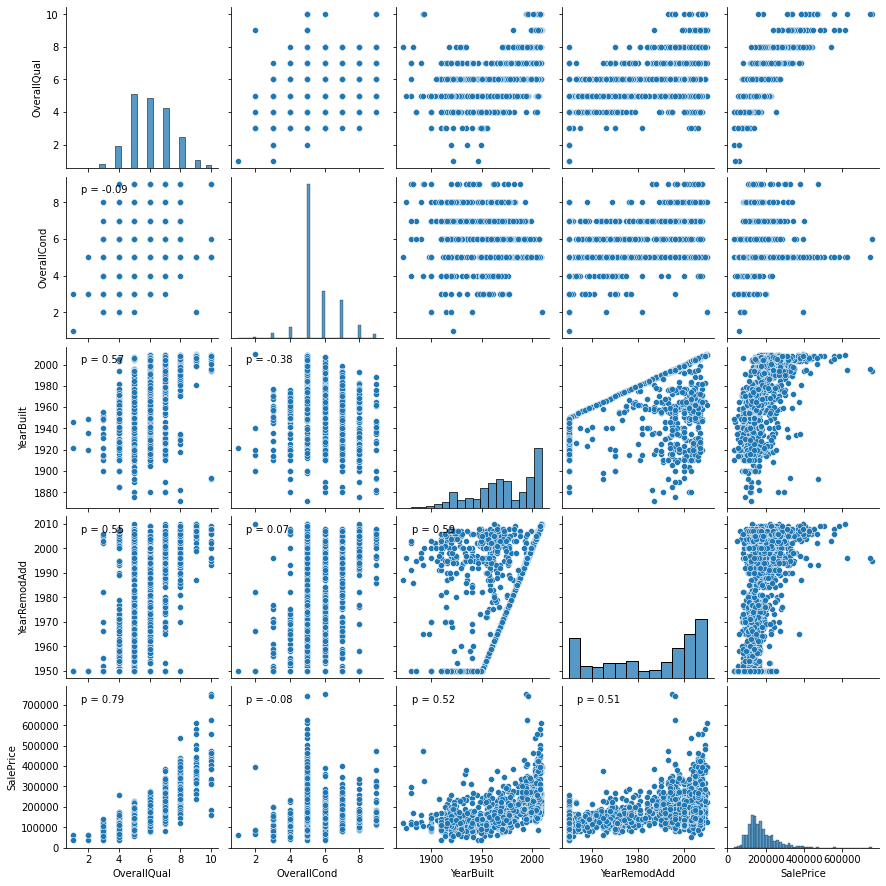

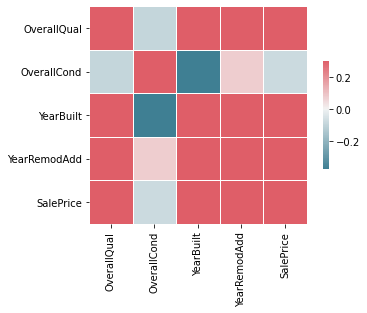

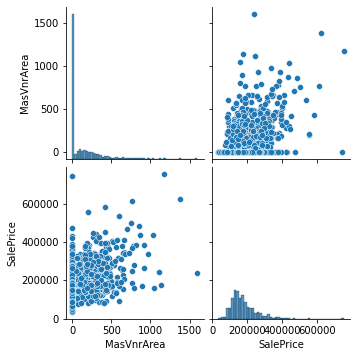

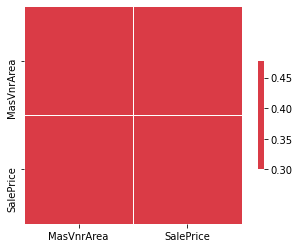

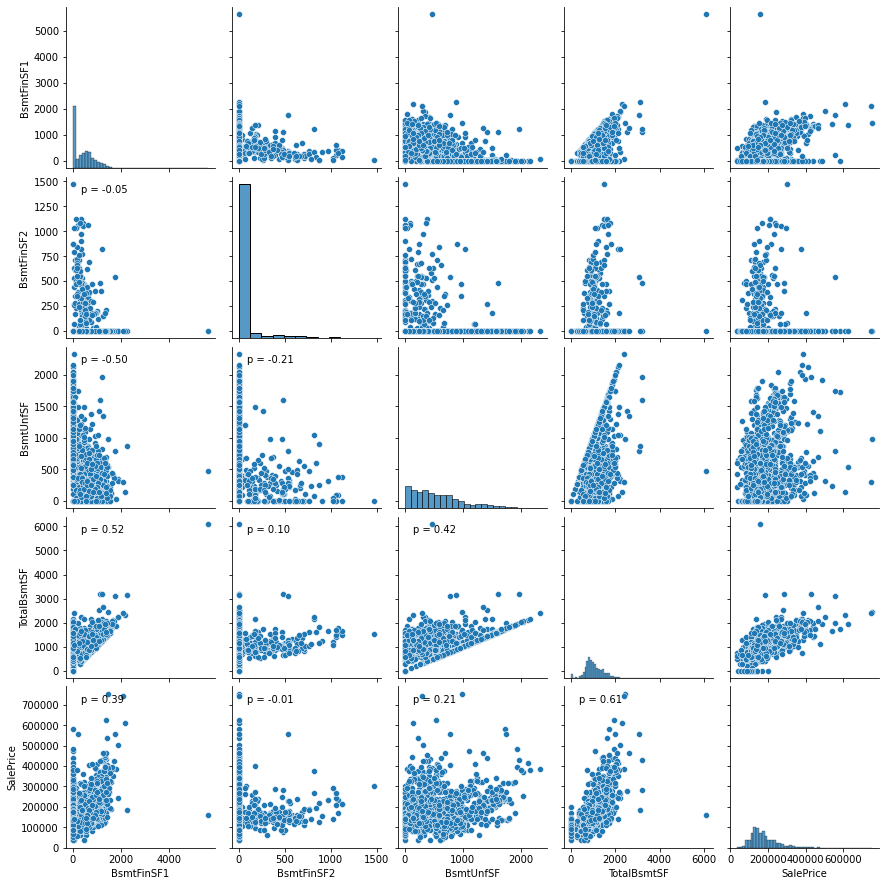

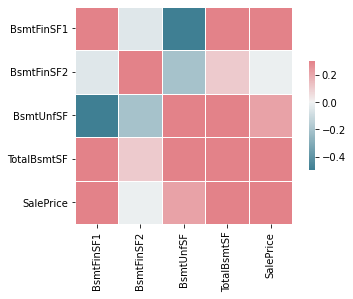

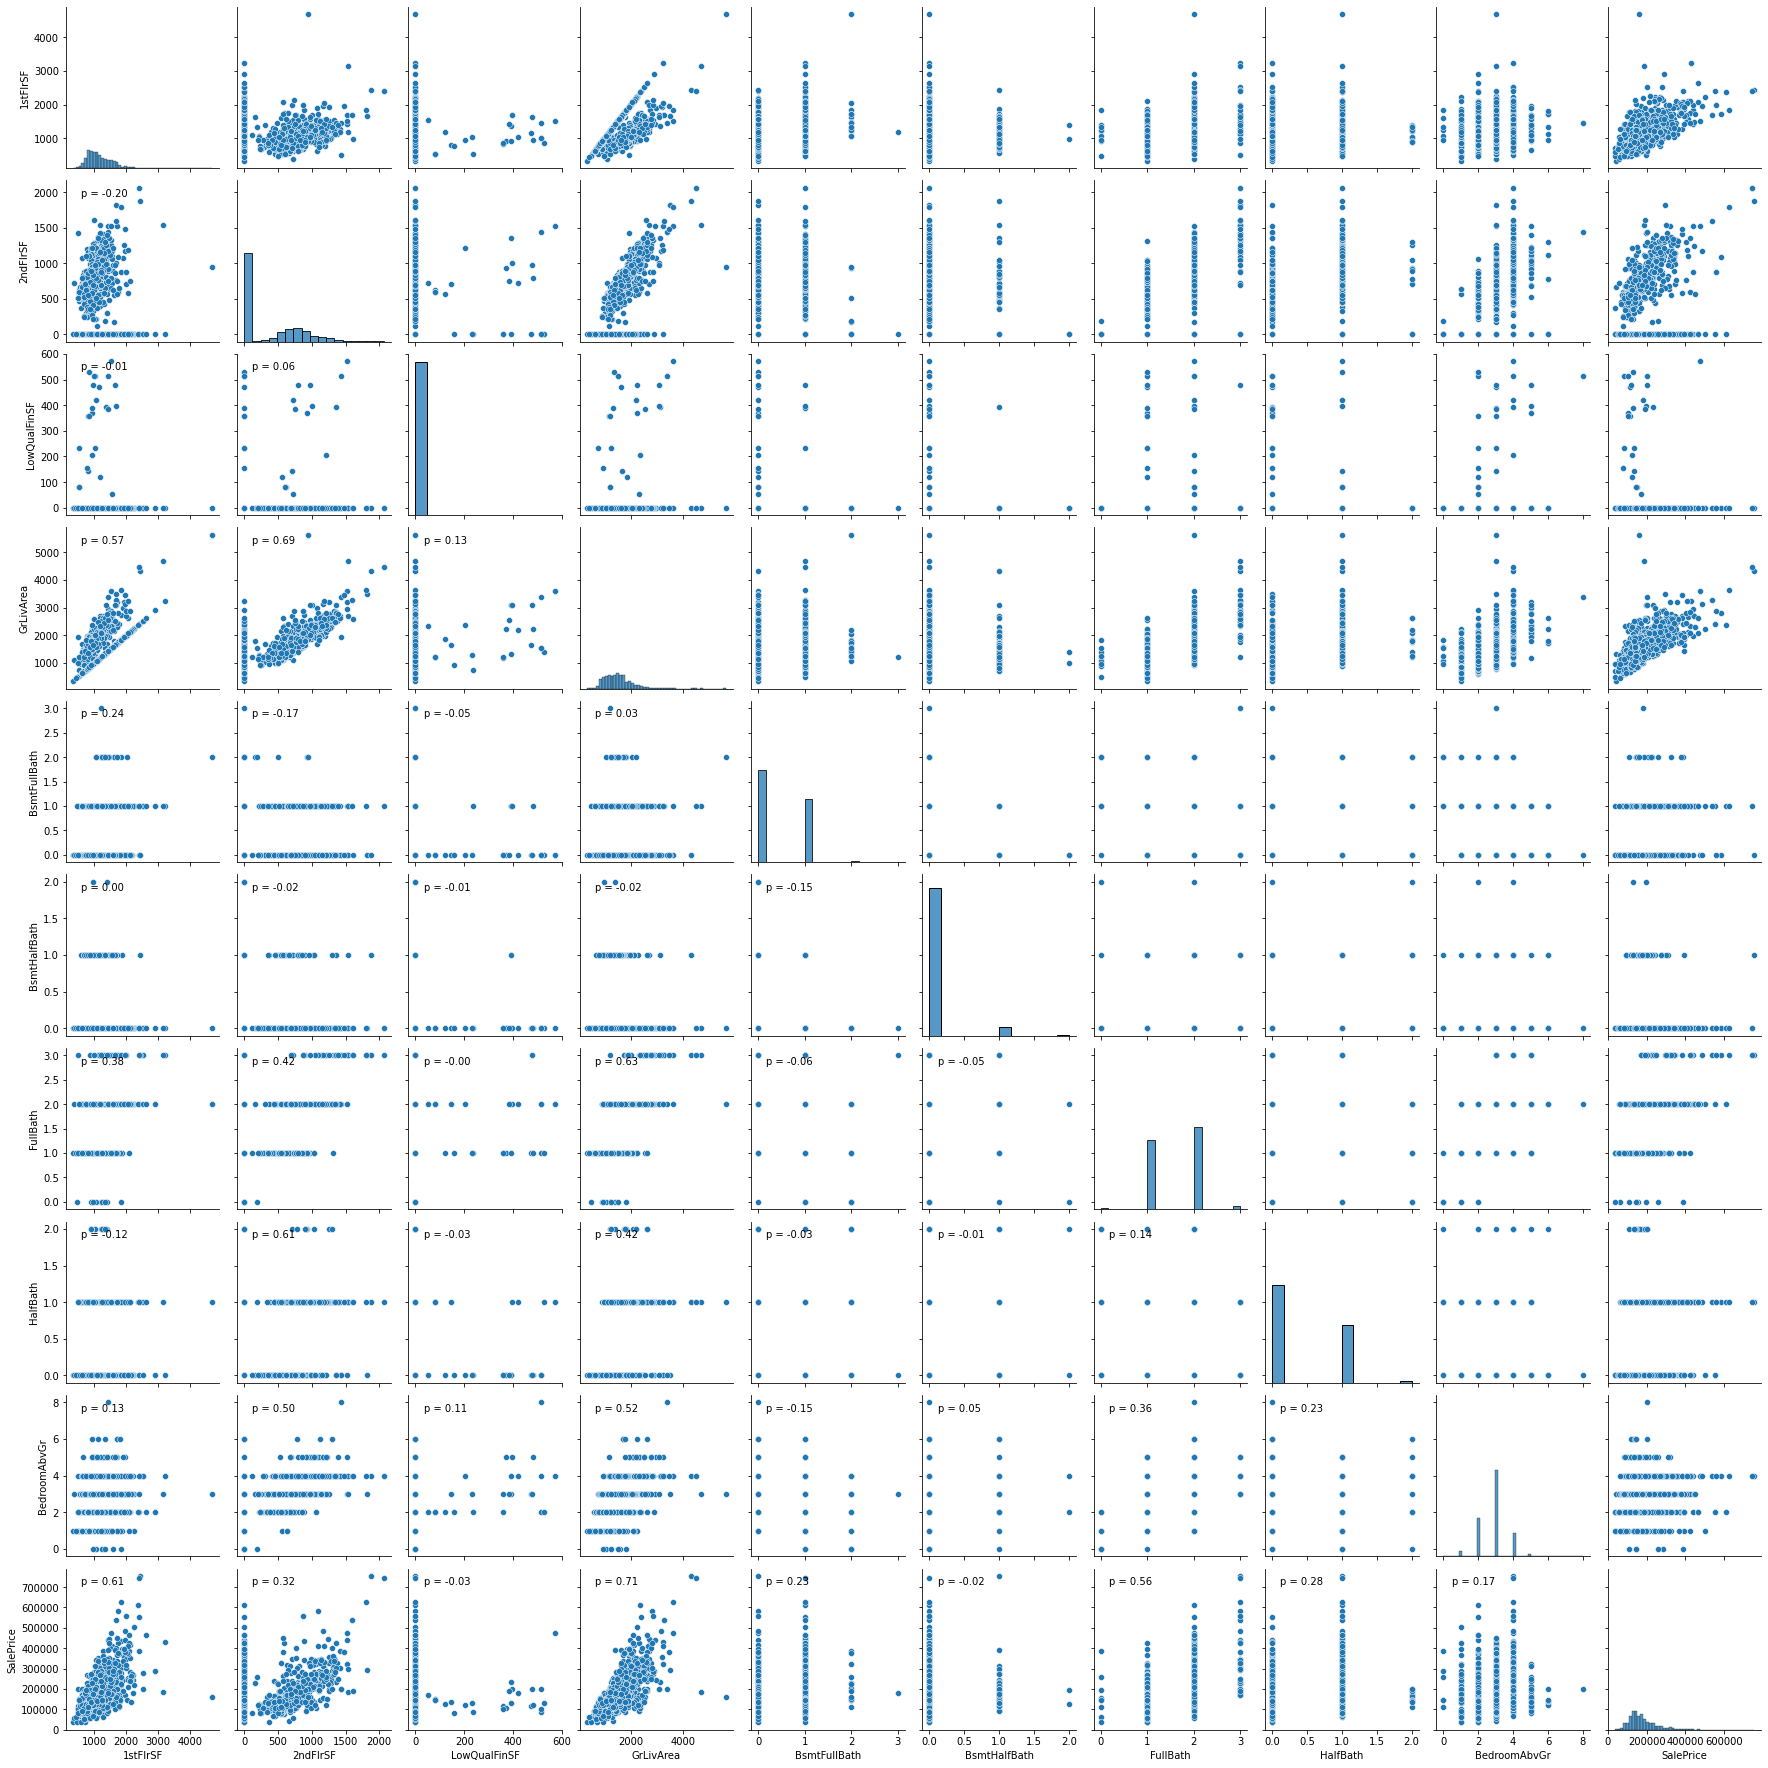

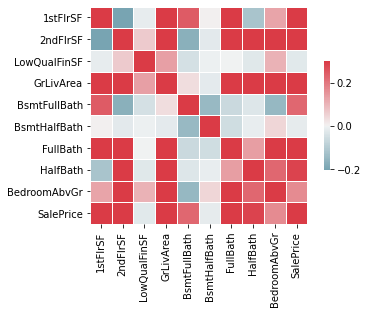

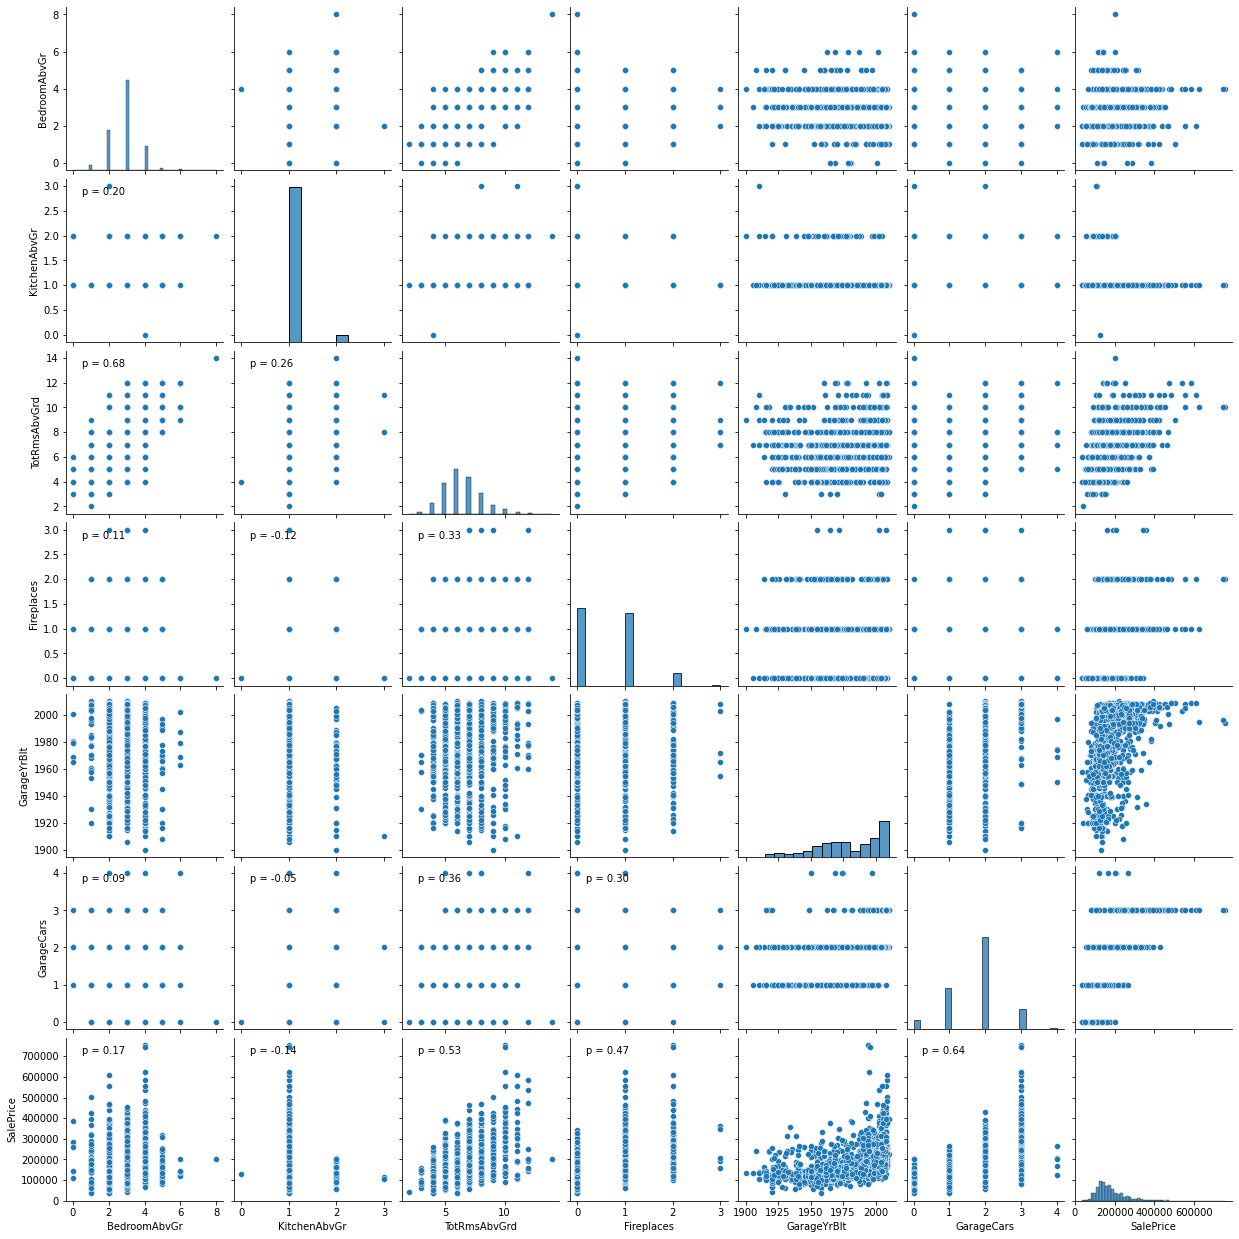

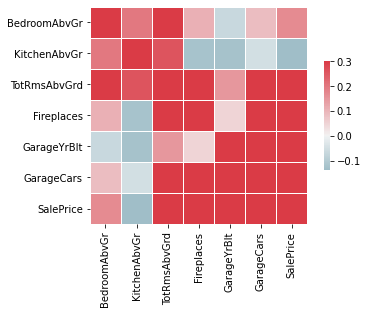

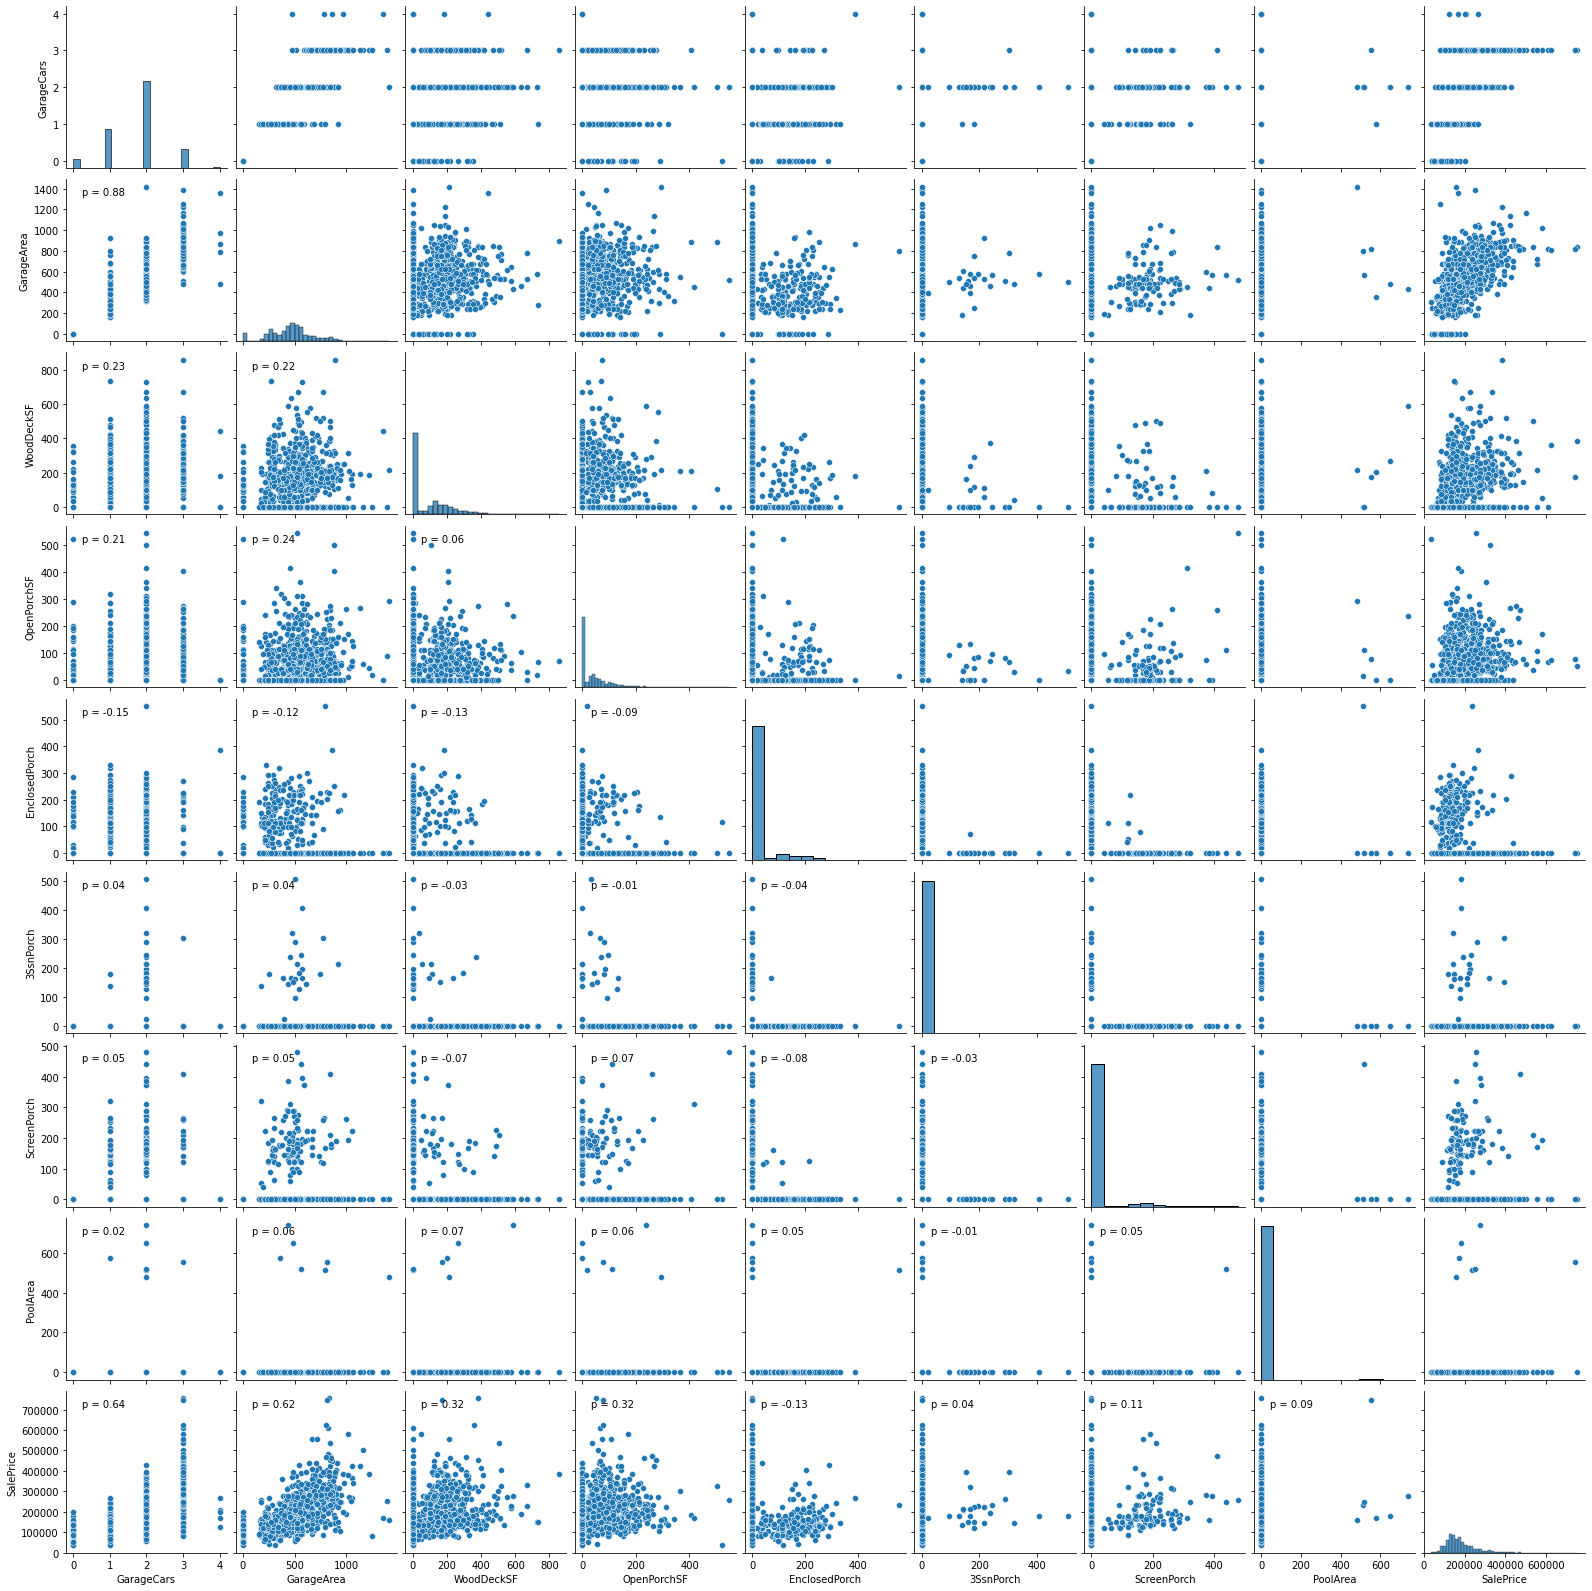

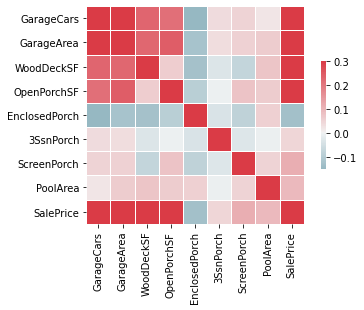

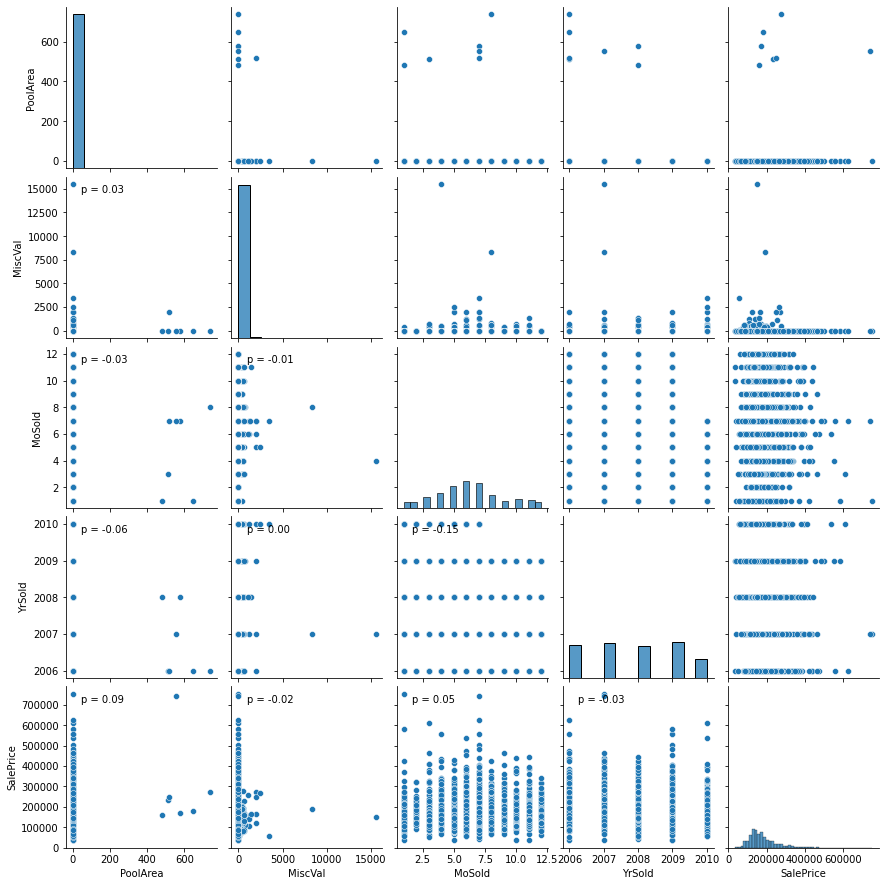

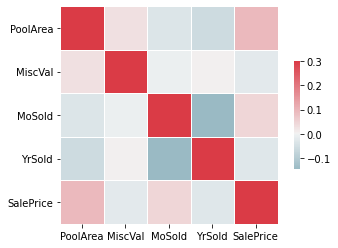

In [9]:
multi_scatmat(df, TARGET_VAR)

<AxesSubplot:>

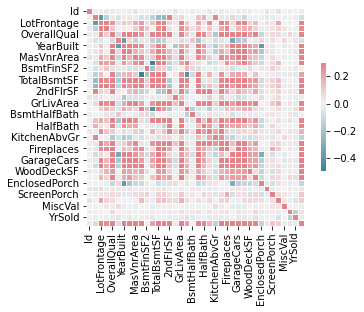

In [10]:
sns.heatmap(df.corr(), vmax=.3, center=0, cmap=CMAP, square=True, linewidths=.5, cbar_kws={"shrink":.5})

<AxesSubplot:>

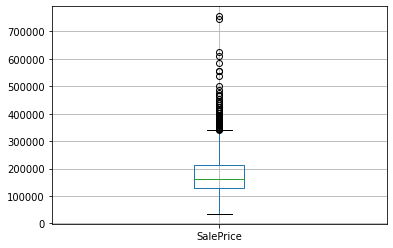

In [142]:
df[['SalePrice']].boxplot()

In [185]:
pd.pivot_table(df, index=['HouseStyle', 'GarageCars'], values="SalePrice")

SalePrice
HouseStyle GarageCars               
1.5Fin     0           102106.250000
           1           128245.903614
           2           169659.360000
           3           255780.000000
1.5Unf     0            99900.000000
           1           117816.666667
           2           107100.000000
1Story     0            97603.750000
           1           124045.193717
           2           179940.608040
           3           297487.505263
           4           145500.000000
2.5Fin     0           152000.000000
           1           149000.000000
           2           194000.000000
           3           385000.000000
2.5Unf     0           128000.000000
           1           132750.000000
           2           178650.000000
2Story     0           116934.615385
           1           137634.758621
           2           197075.051020
           3           327743.910256
           4           232989.500000
SFoyer     0            96500.000000
           1           117057.142857
           2           147524.173913
           4           206300.000000
SLvl       1           144438.888889
           2           175346.086957
           3           169900.000000